# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
print(df.dtypes)

emotion     int64
pixels     object
dtype: object


In [ ]:
## parsing data here
images, labels = parse_data(df)


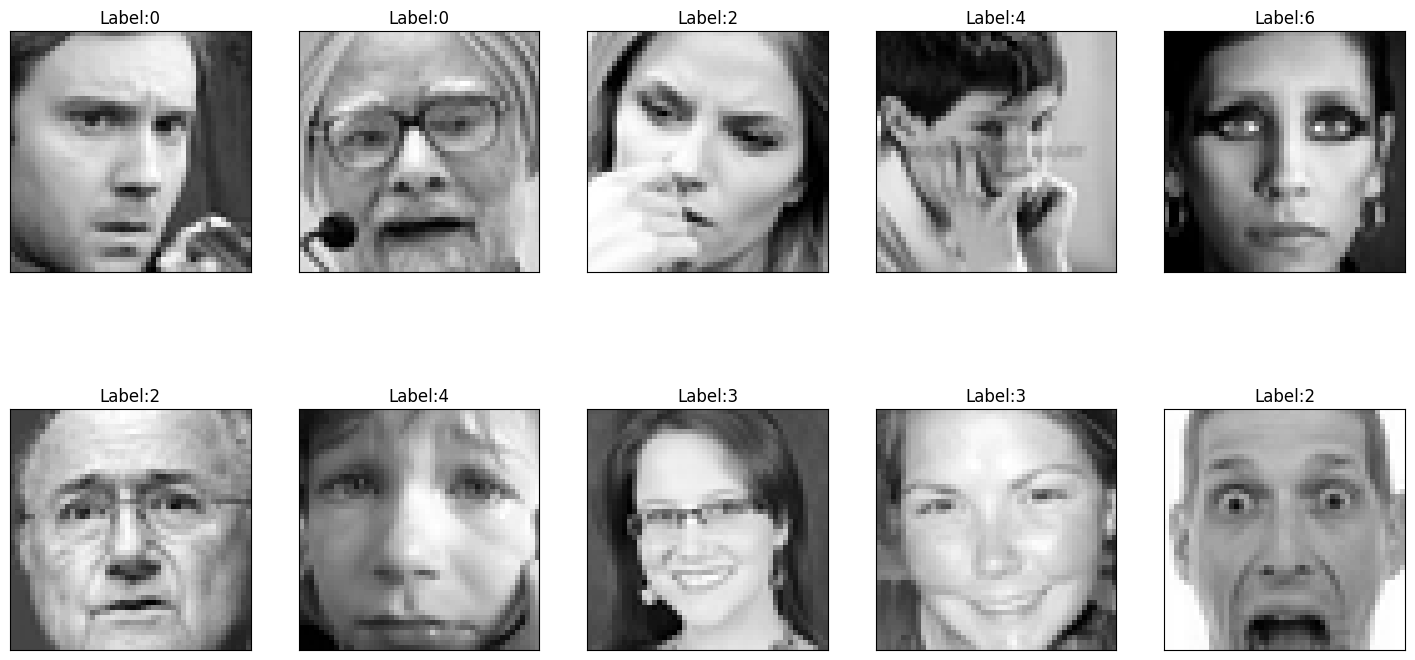

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:
# Chuyển đổi ảnh thành vector
images = images.reshape(len(images), -1)
print(images.shape)

(35887, 2304)


In [ ]:
# Khởi tạo đối tượng PCA với 2 thành phần chính để trực quan hóa
pca_2d = PCA(n_components=2)
images_pca_2d = pca_2d.fit_transform(images)
images_pca_2d.shape

(35887, 2)

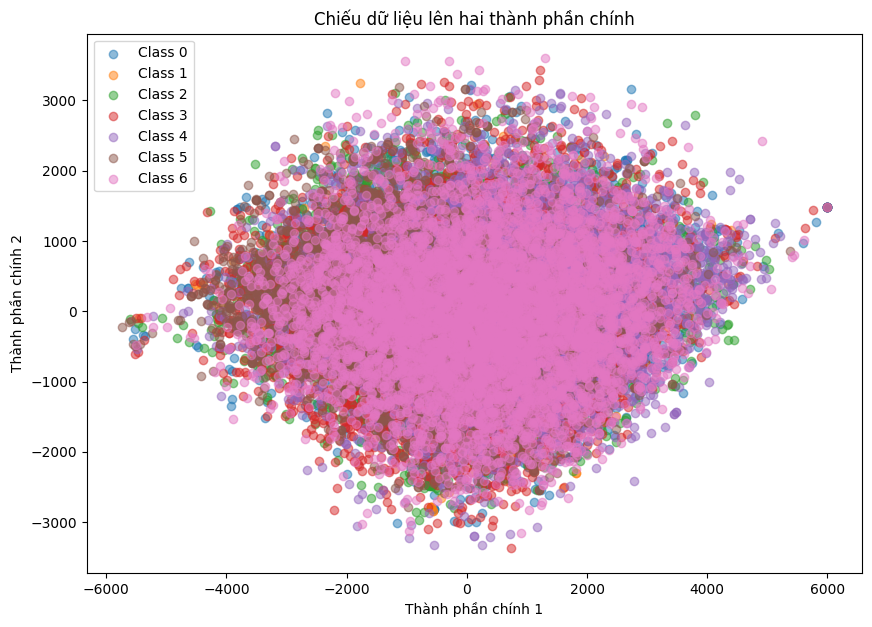

In [ ]:
# Trực quan hóa dữ liệu dựa trên hai thành phần chính
plt.figure(figsize=(10, 7))
for i in range(len(np.unique(labels))):
    subset = images_pca_2d[labels == i]
    plt.scatter(subset[:, 0], subset[:, 1], label=f'Class {i}', alpha=0.5)

plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.legend()
plt.title('Chiếu dữ liệu lên hai thành phần chính')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

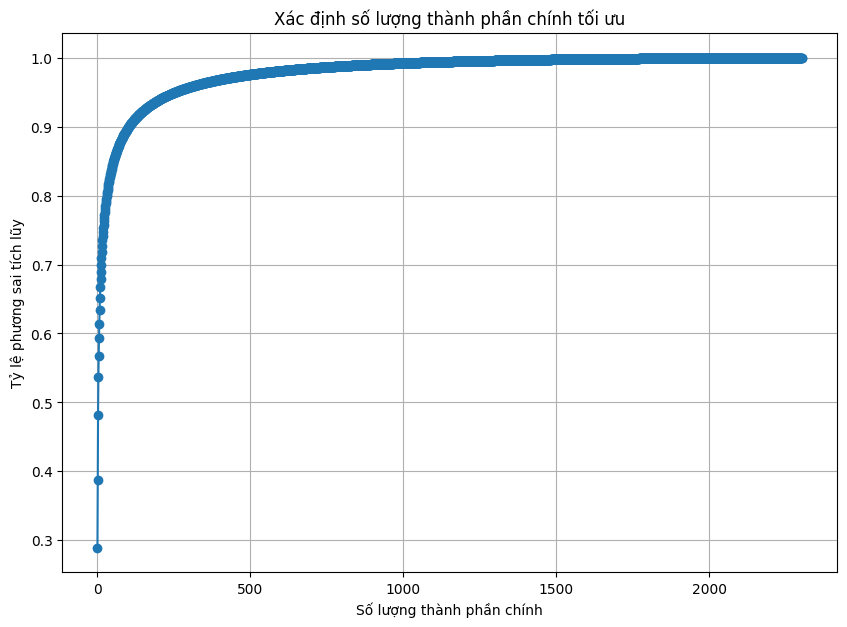

Số lượng thành phần chính tối ưu: 255


In [ ]:
# Khởi tạo đối tượng PCA với số lượng thành phần chính tối đa
pca = PCA()
pca.fit(images)

# Tính tỷ lệ phương sai giải thích được
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Vẽ biểu đồ explained variance ratio để xác định số lượng thành phần chính tối ưu
plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Số lượng thành phần chính')
plt.ylabel('Tỷ lệ phương sai tích lũy')
plt.title('Xác định số lượng thành phần chính tối ưu')
plt.grid(True)
plt.show()

# Xác định số lượng thành phần chính cần thiết để đạt được một tỷ lệ explained variance mong muốn (ví dụ 95%)
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Số lượng thành phần chính tối ưu: {optimal_components}')

Giải thích quá trình lựa chọn
Tạo đối tượng PCA:  tạo một đối tượng PCA và huấn luyện nó trên toàn bộ dữ liệu để tính toán tỷ lệ phương sai giải thích được bởi tất cả các thành phần chính.

Tính tỷ lệ phương sai tích lũy: Sử dụng np.cumsum để tính tỷ lệ phương sai tích lũy từ explained_variance_ratio_.

Vẽ biểu đồ: Biểu đồ này giúp chúng ta hình dung cách tỷ lệ phương sai tích lũy tăng dần theo số lượng thành phần chính. Điểm "uốn" trên biểu đồ thường chỉ ra số lượng thành phần chính tối ưu.

Xác định số lượng thành phần chính tối ưu: Chọn số lượng thành phần chính sao cho tỷ lệ phương sai tích lũy đạt đến một ngưỡng mong muốn, chẳng hạn như 95%. Số lượng thành phần chính này đảm bảo rằng mô hình của chúng ta giữ lại 95% thông tin từ dữ liệu gốc.

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### Prepare Data

In [ ]:
images, labels = parse_data(df)

In [ ]:
# Chia tập train và tập test
X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=10, train_size=0.8)

# Kiểm tra shape của dữ liệu
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48), (7178, 48, 48), (28709,), (7178,))

Original data (Resize ảnh)

In [ ]:
# Hàm resize ảnh
def resize_images(images, width, height):
    resized_images = [cv2.resize(img, (width, height)) for img in images]
    return np.array(resized_images)

In [ ]:
# Thay đổi kích thước ảnh
X_train_resized = resize_images(X_train, width=24, height=24)
X_test_resized = resize_images(X_test, width=24, height=24)

# Chuyển đổi ảnh thành vector
X_train_flattened = X_train_resized.reshape(len(X_train_resized), -1)
X_test_flattened = X_test_resized.reshape(len(X_test_resized), -1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_normalized_train = scaler.fit_transform(X_train_flattened)
X_normalized_test = scaler.transform(X_test_flattened)

Transformed data (PCA)

In [ ]:
# Chuyển đổi ảnh X_train, X_test thành vector
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

# Kiểm tra shape của dữ liệu
X_train.shape, X_test.shape

((28709, 2304), (7178, 2304))

In [ ]:
optimal_components #Số lượng thành phần chính tối ưu tìm được ở phần trên (optimal_components=255)

255

In [ ]:
# Khởi tạo và fit StandardScaler trên X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Áp dụng PCA trên dữ liệu đã scaled
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train_scaled)

# Áp dụng cùng PCA đã học từ X_train_scaled vào X_test
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Kiểm tra shape của dữ liệu sau khi PCA
X_train_pca.shape, X_test_pca.shape

((28709, 255), (7178, 255))

### Logistic Regression


Sử dụng mô hình Logistic Regression trên tập dữ liệu đã được PCA (Transformed data)

In [ ]:
logistic = LogisticRegression(max_iter=100)

# Thiết lập lưới tham số
param_grid ={
    'penalty':['l2'],
    'C': [0.001, 0.01, 0.1, 1.0],
    'solver': ['lbfgs','newton-cg','sag','saga'],
    'multi_class': ['multinomial']
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
clf = GridSearchCV(logistic, param_grid=param_grid, cv=2, verbose=True, n_jobs=-1)
clf.fit(X_train_pca, y_train)

# In ra các tham số tốt nhất tìm được
print("Best parameters found: ", clf.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best parameters found:  {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.26      0.13      0.17       970
           1       1.00      0.01      0.02       113
           2       0.27      0.15      0.19       986
           3       0.44      0.71      0.54      1802
           4       0.32      0.29      0.30      1251
           5       0.47      0.46      0.47       814
           6       0.34      0.36      0.35      1242

    accuracy                           0.38      7178
   macro avg       0.44      0.30      0.29      7178
weighted avg       0.37      0.38      0.35      7178



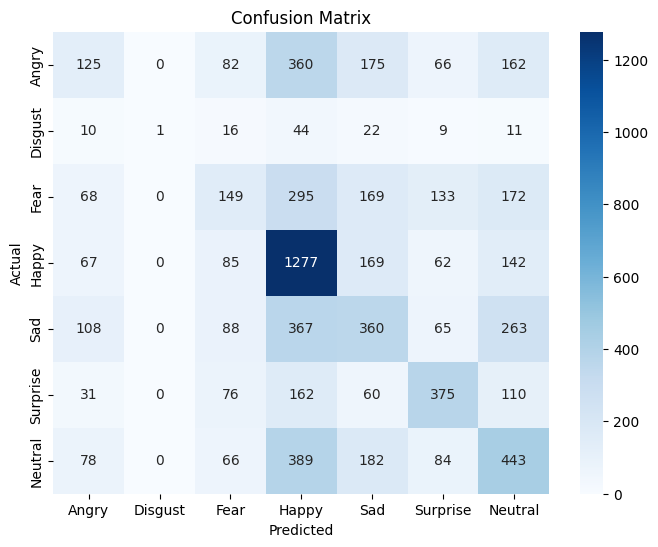

In [ ]:
# Sử dụng mô hình tối ưu để dự đoán
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Vẽ ma trận confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Sử dụng mô hình Logistic Regression trên tập dữ liệu đã được resize (Original data)

In [ ]:
logistic = LogisticRegression(max_iter=100)

# Thiết lập lưới tham số
param_grid ={
    'penalty':['l2'],
    'C': [0.001, 0.01, 0.1, 1.0],
    'solver': ['lbfgs','newton-cg','sag','saga'],
    'multi_class': ['multinomial']
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
clf = GridSearchCV(logistic, param_grid=param_grid, cv=2, verbose=True, n_jobs=-1)
clf.fit(X_normalized_train, y_train)

# In ra các tham số tốt nhất tìm được
print("Best parameters found: ", clf.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best parameters found:  {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}
Best parameters found:  {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}


              precision    recall  f1-score   support

           0       0.27      0.14      0.18       970
           1       0.50      0.01      0.02       113
           2       0.28      0.16      0.20       986
           3       0.44      0.70      0.54      1802
           4       0.32      0.30      0.31      1251
           5       0.47      0.47      0.47       814
           6       0.34      0.36      0.35      1242

    accuracy                           0.38      7178
   macro avg       0.37      0.30      0.30      7178
weighted avg       0.36      0.38      0.36      7178



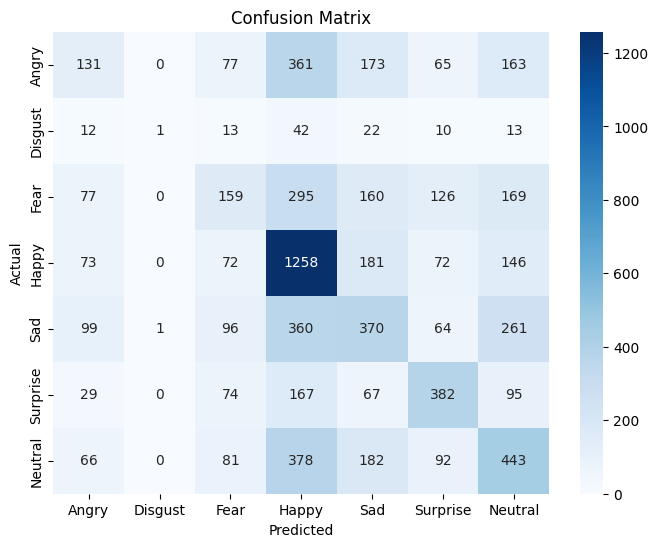

In [ ]:
# Sử dụng mô hình tối ưu để dự đoán
best_model = clf.best_estimator_
y_pred = best_model.predict(X_normalized_test)
print(classification_report(y_test, y_pred))

# Vẽ ma trận confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

 ### SVM


Sử dụng mô hình SVM trên tập dữ liệu đã được PCA (Transformed data)

In [ ]:
svm = SVC()

# Thiết lập lưới tham số
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale']
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
clf = GridSearchCV(svm, param_grid=param_grid, cv=2, verbose=True, n_jobs=-1)
clf.fit(X_train_pca, y_train)

# In ra các tham số tốt nhất tìm được
print("Best parameters found: ", clf.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       0.36      0.34      0.35       970
           1       0.77      0.36      0.49       113
           2       0.38      0.38      0.38       986
           3       0.56      0.67      0.61      1802
           4       0.39      0.36      0.38      1251
           5       0.68      0.61      0.64       814
           6       0.44      0.42      0.43      1242

    accuracy                           0.48      7178
   macro avg       0.51      0.45      0.47      7178
weighted avg       0.47      0.48      0.47      7178



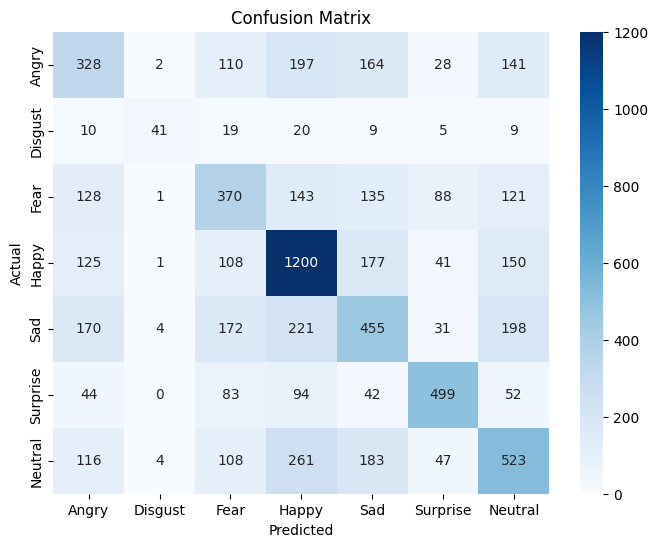

In [ ]:
# Sử dụng mô hình tối ưu để dự đoán
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Vẽ ma trận confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Sử dụng mô hình SVM trên tập dữ liệu đã được resize (Original data)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 3189
max_resources_: 28709
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 3189
Fitting 2 folds for each of 9 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 3
n_resources: 9567
Fitting 2 folds for each of 3 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 1
n_resources: 28701
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.41      0.22      0.29       970
           1       1.00      0.04      0.08       113
           2       0.42      0.25      0.32       986
           3       0.50      0.75      0.60      1802
           4       0.37      0.40      0.38      1251
           5       0.63      0.52      0.57       814
           6       0.41      0.43      0.42      1242

    accurac

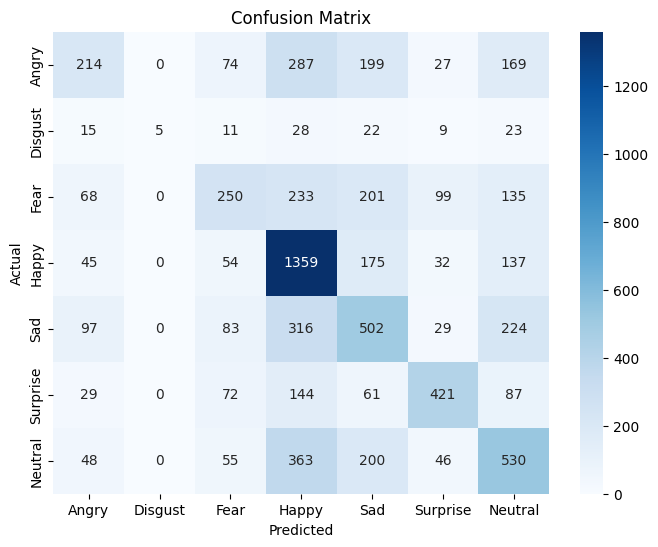

In [ ]:
svm = SVC()

# Thiết lập lưới tham số
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100],
    'gamma': ['scale'] }

# Sử dụng HalvingGridSearchCV thay cho GridSearchCV để tìm kiếm các tham số nhanh hơn
clf = HalvingGridSearchCV(svm, param_grid=param_grid, cv=2, verbose=3, n_jobs=-1)
clf.fit(X_normalized_train, y_train)

# In ra các tham số tốt nhất tìm được
print("Best parameters found: ", clf.best_params_)

# Sử dụng mô hình tối ưu để dự đoán
best_model = clf.best_estimator_
y_pred = best_model.predict(X_normalized_test)
print(classification_report(y_test, y_pred))

# Vẽ ma trận confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

Sử dụng mô hình Random Forest trên tập dữ liệu đã được PCA (Transformed data)

In [ ]:
clf = RandomForestClassifier(random_state=42)

# Thiết lập lưới tham số
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini']
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [50, 100]},
             verbose=2)

In [ ]:
# In ra các tham số tốt nhất tìm được
best_params = grid_search.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}


In [ ]:
# Sử dụng mô hình tối ưu để dự đoán
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_pca)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.3879910838673725
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.10      0.17       970
           1       1.00      0.06      0.12       113
           2       0.54      0.17      0.26       986
           3       0.33      0.91      0.49      1802
           4       0.41      0.20      0.26      1251
           5       0.76      0.43      0.55       814
           6       0.39      0.23      0.29      1242

    accuracy                           0.39      7178
   macro avg       0.57      0.30      0.31      7178
weighted avg       0.48      0.39      0.34      7178



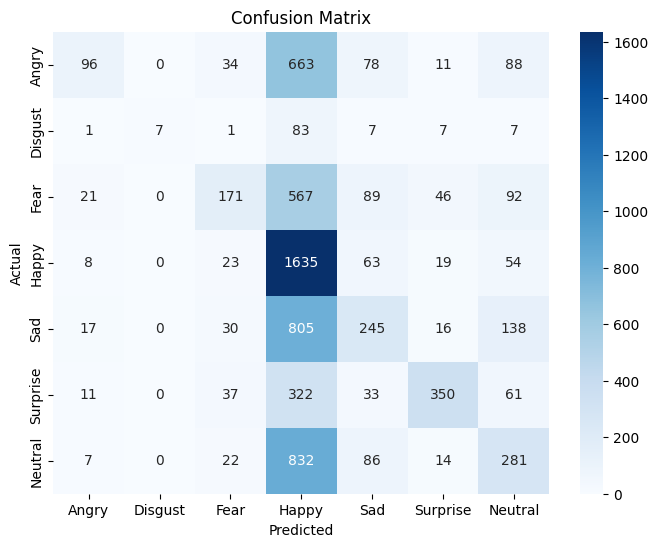

In [ ]:
# Tính toán ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa các nhãn của lớp
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Sử dụng mô hình Random Forest trên tập dữ liệu đã được resize (Original data)

In [ ]:
clf = RandomForestClassifier(random_state=42)

# Thiết lập lưới tham số
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini']
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_normalized_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [50, 100]},
             verbose=2)

In [ ]:
# In ra các tham số tốt nhất tìm được
best_params = grid_search.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.57      0.18      0.28       970
           1       1.00      0.12      0.21       113
           2       0.46      0.23      0.30       986
           3       0.44      0.82      0.57      1802
           4       0.39      0.36      0.37      1251
           5       0.63      0.57      0.59       814
           6       0.42      0.39      0.41      1242

    accuracy                           0.46      7178
   macro avg       0.56      0.38      0.39      7178
weighted avg       0.48      0.46      0.43      7178



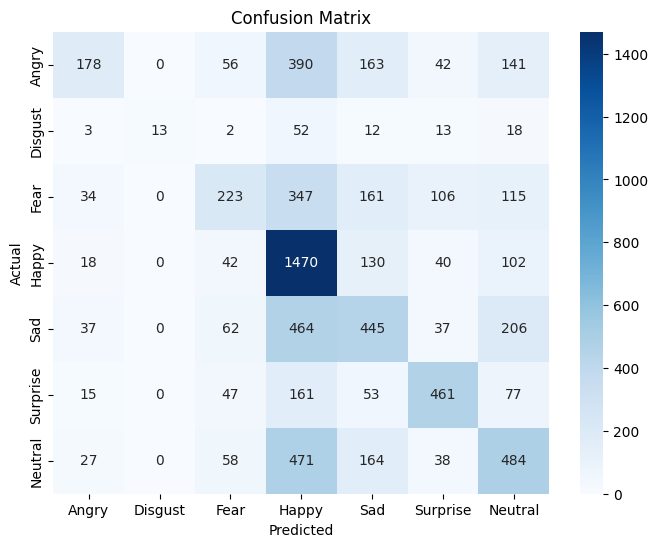

In [ ]:
# Sử dụng mô hình tối ưu để dự đoán
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_normalized_test)
print(classification_report(y_test, y_pred))

# vẽ ma trận confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### MLP


Sử dụng mô hình Random Forest trên tập dữ liệu đã được PCA (Transformed data)

In [ ]:
mlp = MLPClassifier(max_iter=100)

# Thiết lập lưới tham số
parameter_space = {
    'hidden_layer_sizes': [(50,50), (50,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
clf = GridSearchCV(estimator=mlp, param_grid=parameter_space, cv=2, n_jobs=-1, verbose=2)
clf.fit(X_train_pca, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50), (50, 100)],
                         'learning_rate': ['constant'], 'solver': ['adam']},
             verbose=2)

In [ ]:
# In ra các tham số tốt nhất tìm được
print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.328 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.329 (+/-0.010) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.337 (+/-0.006) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.332 (+/-0.009) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.285 (+/-0.034) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.300 (+/-0.013) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.304 (+/-0.013) for

Test Accuracy: 0.34772917247144053
Test Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.19      0.22       970
           1       0.18      0.24      0.21       113
           2       0.25      0.29      0.27       986
           3       0.46      0.56      0.51      1802
           4       0.33      0.13      0.19      1251
           5       0.50      0.39      0.44       814
           6       0.27      0.40      0.32      1242

    accuracy                           0.35      7178
   macro avg       0.32      0.32      0.31      7178
weighted avg       0.35      0.35      0.34      7178



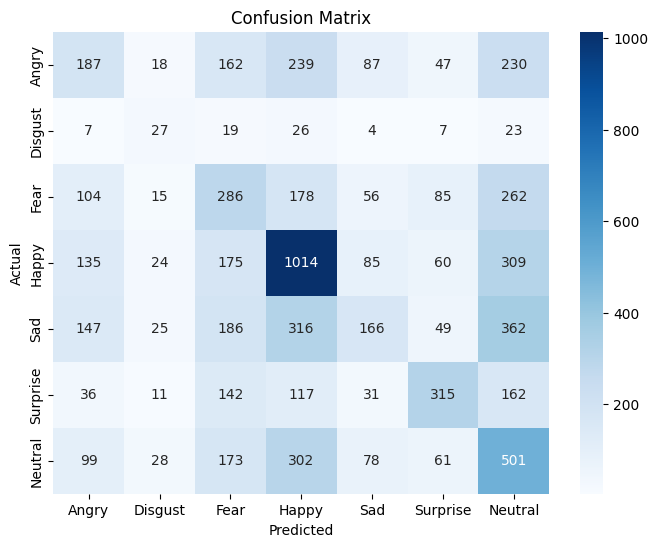

In [ ]:
# Sử dụng mô hình tối ưu để dự đoán
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test_pca)

# Đánh giá mô hình trên tập kiểm thử
accuracy_test = accuracy_score(y_test, y_pred)
report_test = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy_test}")
print("Test Classification Report:")
print(report_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Sử dụng mô hình MLP trên tập dữ liệu đã được resize (Original data)

In [ ]:
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50), (50,100),],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}
# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
clf = GridSearchCV(estimator=mlp, param_grid=parameter_space, cv=2, n_jobs=-1, verbose=2)
clf.fit(X_normalized_train, y_train)


Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50), (50, 100)],
                         'learning_rate': ['constant'], 'solver': ['adam']},
             verbose=2)

In [ ]:
# In ra các tham số tốt nhất tìm được
print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.232 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.236 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.233 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.236 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.240 (+/-0.013) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.231 (+/-0.000) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.233 (+/-0.002) f

Test Accuracy: 0.24352187238785178
Test Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.16      0.17       970
           1       0.00      0.00      0.00       113
           2       0.18      0.13      0.15       986
           3       0.28      0.50      0.36      1802
           4       0.22      0.19      0.20      1251
           5       0.32      0.25      0.28       814
           6       0.21      0.10      0.14      1242

    accuracy                           0.24      7178
   macro avg       0.20      0.19      0.18      7178
weighted avg       0.23      0.24      0.22      7178



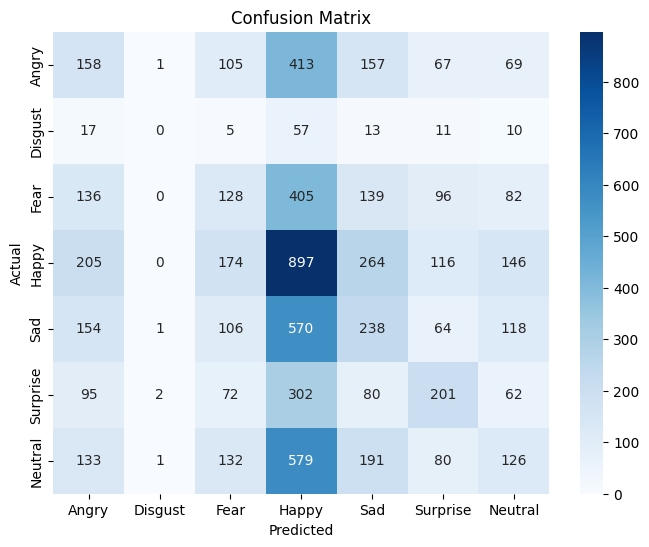

In [ ]:
# Sử dụng mô hình tối ưu để dự đoán
best_model = clf.best_estimator_
y_pred = best_model.predict(X_normalized_test)

# Đánh giá mô hình trên tập kiểm thử
accuracy_test = accuracy_score(y_test, y_pred)
report_test = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy_test}")
print("Test Classification Report:")
print(report_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



### Tóm tắt số liệu đánh giá trên dữ liệu đã resize (Original data)

#### Logistic Regression
- **Accuracy**: 0.38
- **Precision**: Weighted avg = 0.36
- **Recall**: Weighted avg = 0.38
- **F1-Score**: Weighted avg = 0.36


#### SVM
- **Accuracy**: 0.46
- **Precision**: Weighted avg = 0.46
- **Recall**: Weighted avg = 0.46
- **F1-Score**: Weighted avg = 0.44

#### Random Forest
- **Accuracy**: 0.46
- **Precision**: Weighted avg = 0.48
- **Recall**: Weighted avg = 0.46
- **F1-Score**: Weighted avg = 0.43

#### MLP
- **Accuracy**: 0.24
- **Precision**: Weighted avg = 0.23
- **Recall**: Weighted avg = 0.24
- **F1-Score**: Weighted avg = 0.22

### Tóm tắt số liệu đánh giá trên dữ liệu đã PCA (Transformed data)

#### Logistic Regression
- **Accuracy**: 0.38
- **Precision**: Weighted avg = 0.37
- **Recall**: Weighted avg = 0.38
- **F1-Score**: Weighted avg = 0.35

#### SVM
- **Accuracy**: 0.48
- **Precision**: Weighted avg = 0.47
- **Recall**: Weighted avg = 0.48
- **F1-Score**: Weighted avg = 0.47

#### Random Forest
- **Accuracy**: 0.39
- **Precision**: Weighted avg = 0.48
- **Recall**: Weighted avg = 0.39
- **F1-Score**: Weighted avg = 0.34

#### MLP
- **Accuracy**: 0.35
- **Precision**: Weighted avg = 0.35
- **Recall**: Weighted avg = 0.35
- **F1-Score**: Weighted avg = 0.34

### Tổng hợp

#### So sánh giữa các mô hình trên dữ liệu đã resize (Original data)
- **SVM** và **Random Forest** có hiệu suất tốt nhất với **accuracy** là 0.46.
- **SVM** có **precision** và **recall** tương đối cân bằng, trong khi **Random Forest** có **precision** cao nhất nhưng chênh lệch giữa **precision** và **recall**.

#### So sánh giữa các mô hình trên dữ liệu đã PCA (Transformed data)
- **SVM** có hiệu suất tốt nhất với **accuracy** là 0.48, theo sau là **Logistic Regression** với **accuracy** là 0.38.
- **Random Forest** trên dữ liệu đã PCA có **precision** tốt nhưng **recall** thấp hơn so với SVM.

#### So sánh giữa dữ liệu đã resize và dữ liệu đã PCA
- **SVM** và **Logistic Regression** có hiệu suất tốt hơn trên dữ liệu đã PCA.
- **Random Forest** có hiệu suất tốt hơn trên dữ liệu đã resize.

### Loại cảm xúc mà mô hình mắc lỗi nhiều nhất
- **Lớp cảm xúc "Disgust" (Class 1)** là lớp mà các mô hình mắc lỗi nhiều nhất, đặc biệt là với **Logistic Regression** và **MLP**. Precision và recall cho lớp này rất thấp, điều này có thể do dữ liệu không cân bằng.
- **Lớp cảm xúc "Happy" (Class 3)** là lớp mà các mô hình phân loại tốt nhất, đặc biệt là với **SVM** và **Random Forest**. Precision và recall cho lớp này cao nhất trong tất cả các mô hình, cho thấy mô hình nhận diện lớp này tốt hơn các lớp khác cũng một phần lớp này có nhiều dữ liệu nhất.

### Kết luận
- **SVM** là mô hình hoạt động tốt nhất trên cả dữ liệu đã resize và PCA, đặc biệt là với **dữ liệu đã PCA**.
- **Random Forest** cũng hoạt động tốt trên dữ liệu đã resize, với độ chính xác gần như SVM nhưng với sự cân bằng precision-recall khác nhau.
- **Logistic Regression** và **MLP** có hiệu suất kém hơn so với SVM và Random Forest, đặc biệt là với dữ liệu đã resize.